In [116]:
import gym
import numpy as np
import pandas as pd
#from mdptoolbox import example, mdp
from hiive.mdptoolbox import mdp, example
from matplotlib import pyplot as plt

In [26]:
P,R = example.forest(S=1000)

In [27]:
P

array([[[0.1, 0.9, 0. , ..., 0. , 0. , 0. ],
        [0.1, 0. , 0.9, ..., 0. , 0. , 0. ],
        [0.1, 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0.1, 0. , 0. , ..., 0. , 0.9, 0. ],
        [0.1, 0. , 0. , ..., 0. , 0. , 0.9],
        [0.1, 0. , 0. , ..., 0. , 0. , 0.9]],

       [[1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ]]])

In [23]:
vi = mdp.ValueIteration(P, R, 0.9, max_iter=10000, epsilon = 0.01)
vi.setVerbose()
a = vi.run()
vi_policy = vi.policy

 Iteration   Variation
         1    4.000000
         2    3.240000
         3    2.697300
         4    2.191374
         5    1.828748
         6    1.490905
         7    1.247671
         8    1.021229
         9    0.857339
        10    0.704896
        11    0.593881
        12    0.490725
        13    0.415064
        14    0.344842
        15    0.292913
        16    0.244781
        17    0.208857
        18    0.175610
        19    0.150540
        20    0.127376
        21    0.109711
        22    0.093419
        23    0.080844
        24    0.069269
        25    0.060221
        26    0.051908
        27    0.045326
        28    0.039290
        29    0.034448
        30    0.030018
        31    0.026417
        32    0.023128
        33    0.020422
        34    0.017956
        35    0.015902
        36    0.014034
        37    0.012461
        38    0.011032
        39    0.009818
Iterating stopped, epsilon-optimal policy found.


In [120]:
vi = mdp.PolicyIterationModified(P, R, 0.9, max_iter=1000, epsilon = 0.01)
vi.setVerbose()
vi.run()
pi_policy = vi.policy

 Iteration   Variation
         1    4.000000
         2   14.145695
         3   10.905536
         4    8.281004
         5    6.155131
         6    4.433173
         7    3.038385
         8    1.908607
         9    0.993486
        10    0.252238
        11    0.000142


In [25]:
sum([pi_policy[i] - vi_policy[i] for i in range(len(pi_policy))])

0

In [117]:
res_pi = pd.read_csv('pi-forest.csv')
res_vi = pd.read_csv('vi-forest.csv')

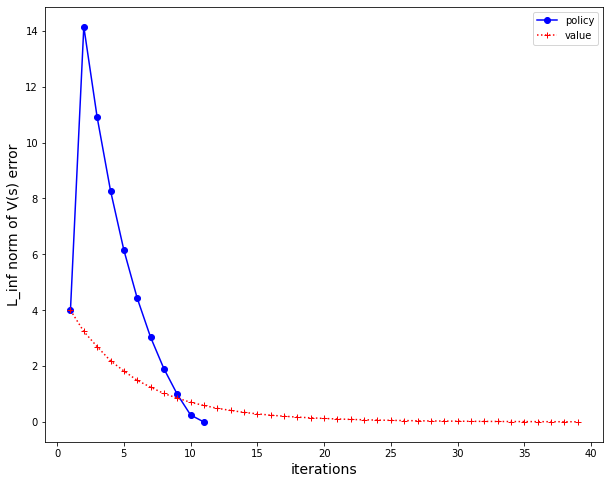

In [118]:
plt.figure(figsize=(10,8))
plt.plot(range(1,len(res_pi)+1), res_pi['V-variation'],'b-o',label='policy')
plt.plot(range(1,len(res_vi)+1), res_vi['V-variation'],'r:+',label='value')
plt.ylabel('L_inf norm of V(s) error',size=14)
plt.xlabel('iterations',size=14)
plt.legend()
plt.show()

In [105]:
class QLearningAgent(object):
    def __init__(self, S = 1000, alpha = 1, gamma = 0.9, eps = 1.0
                 , eps_decay = 0.99999, min_eps = 0.1, max_step = 10001,max_iter = 10
                , method = 'random', adaptive_alpha = True, start_from0 = False):
        self.Q = None
        self.alpha = 1
        self.gamma = 0.9
        self.S = S
        self.P,self.R  = example.forest(S = S)
        self.max_step = max_step
        self.min_eps = min_eps
        self.max_iter = max_iter
        self.eps_decay = eps_decay
        self.eps = eps
        self.method = method
        self.adaptive_alpha = adaptive_alpha
        self.start_from0 = start_from0
    def act(self, s):
        if self.method == 'random':
            return np.random.choice(2)
        elif self.method == 'eps_greedy':
            tmp = np.random.rand()
            #print(tmp)
            if tmp <= self.eps:
                return np.random.choice(2)
            else:
                #print('best')
                return self.Q[s].argmax()
        elif self.method == 'best':
            return self.Q[s].argmax()

    def solve(self, optimal_agent = None):
        """Create the Q table"""
        self.Q = np.ones((self.S, 2))
        res = {'it':[], 'act_diff':[], 'l_inf':[], 'l_2':[]}
        for i in range(self.max_step):
            if optimal_agent and i%100==0:
                res['it'].append(i)
                res['act_diff'].append(self.policy_err(optimal_agent))
                e1,e2 = self.v_err(optimal_agent)
                res['l_inf'].append(e1)
                res['l_2'].append(e2)
            if self.start_from0:
                cur_state = 0
            else:
                cur_state = i%self.S
  
            for j in range(self.max_iter):
                cur_action = self.act(cur_state)
                
                reward = R[cur_state][cur_action]
                if cur_action == 1:
                    next_state = 0
                else:
                    rand_num = np.random.rand()
                    if rand_num <= 0.9:
                        next_state = min(cur_state + 1, self.S-1)
                    else:
                        next_state = 0

                next_q = max(self.Q[next_state])
                self.Q[cur_state][cur_action] += self.alpha * (reward + self.gamma * next_q - self.Q[cur_state][cur_action]) 
                cur_state = next_state
            self.eps = max(self.eps*self.eps_decay, self.min_eps)
            if self.adaptive_alpha:
                self.alpha = max(self.alpha*self.eps_decay, self.min_eps)
        return res
    def Q_table(self, state, action):
        """return the optimal value for State-Action pair in the Q Table"""
        return self.Q[state][action]
    
    def policy_err(self, optimal_agent):
        cur_policy = self.Q.argmax(axis=1)
        return sum(cur_policy != optimal_agent.policy)
    def v_err(self, optimal_agent):
        return np.linalg.norm(self.Q.max(axis=1) - optimal_agent.V,ord = np.inf ),np.linalg.norm(self.Q.max(axis=1) - optimal_agent.V,ord = 2 )

In [106]:
q_agent = QLearningAgent(method = 'random',adaptive_alpha = False,start_from0 = True)
res0 = q_agent.solve(vi)

In [107]:
q_agent = QLearningAgent(method = 'random',adaptive_alpha = False)
res1 = q_agent.solve(vi)

In [108]:
q_agent = QLearningAgent(method = 'random')
res2 = q_agent.solve(vi)

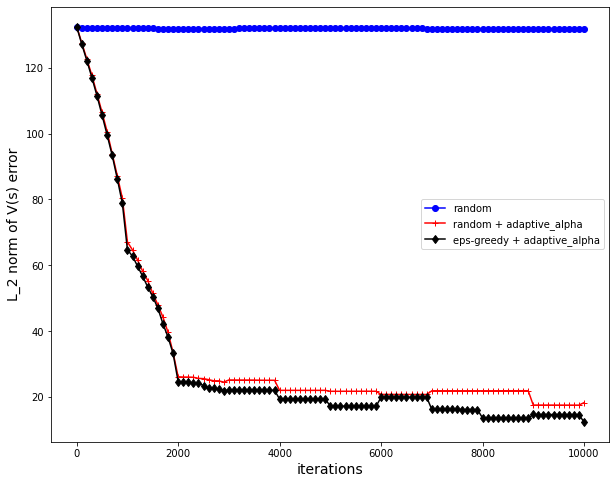

In [109]:
plt.figure(figsize=(10,8))
plt.plot(res0['it'], res0['l_2'],'b-o',label='random')
plt.plot(res1['it'], res1['l_2'],'r-+',label='random + diff_start')
plt.plot(res2['it'], res2['l_2'],'k-d',label='random + diff_start + adaptive_alpha')
plt.ylabel('L_2 norm of V(s) error',size=14)
plt.xlabel('iterations',size=14)
plt.legend()
plt.show()

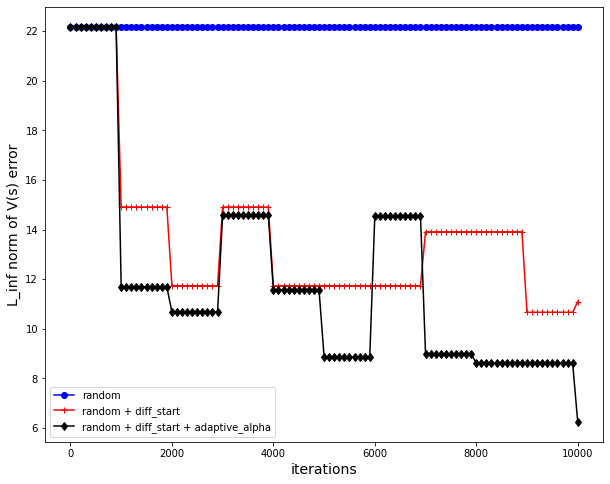

In [113]:
plt.figure(figsize=(10,8))
plt.plot(res0['it'], res0['l_inf'],'b-o',label='random')
plt.plot(res1['it'], res1['l_inf'],'r-+',label='random + diff_start')
plt.plot(res2['it'], res2['l_inf'],'k-d',label='random + diff_start + adaptive_alpha')
plt.ylabel('L_inf norm of V(s) error',size=14)
plt.xlabel('iterations',size=14)
plt.legend()
plt.show()

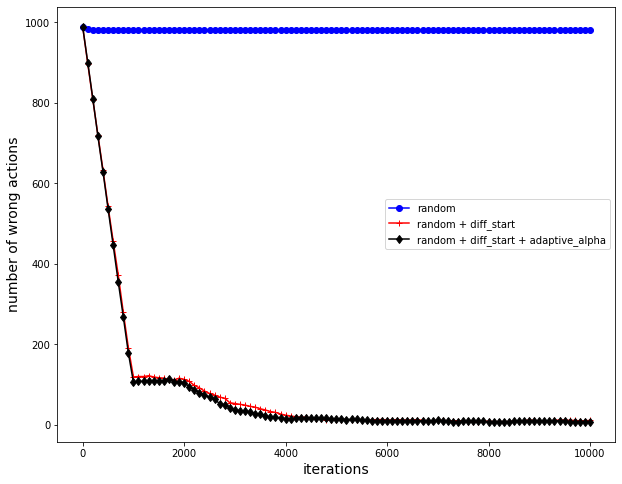

In [114]:
plt.figure(figsize=(10,8))
plt.plot(res0['it'], res0['act_diff'],'b-o',label='random')
plt.plot(res1['it'], res1['act_diff'],'r-+',label='random + diff_start')
plt.plot(res2['it'], res2['act_diff'],'k-d',label='random + diff_start + adaptive_alpha')
plt.ylabel('number of wrong actions',size=14)
plt.xlabel('iterations',size=14)
plt.legend()
plt.show()